<a href="https://colab.research.google.com/github/duonghung86/Injury-severity-classification/blob/main/VCA_3_0_binary_models_MLs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import time
from collections import Counter

# Import dataset

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/duonghung86/Injury-severity-classification/main/final%20data%20nomap.csv')
print(df.shape)
df.head()

(468844, 41)


,Unit_Nbr,Prsn_Type_ID,Prsn_Occpnt_Pos_ID,Prsn_Injry_Sev_ID,Prsn_Age,Prsn_Ethnicity_ID,Prsn_Gndr_ID,Prsn_Ejct_ID,Prsn_Rest_ID,Prsn_Airbag_ID,Prsn_Helmet_ID,Prsn_Drg_Rslt_ID,Day_of_Week,Rpt_Rdwy_Sys_ID,Rpt_Road_Part_ID,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,At_Intrsct_Fl,Wthr_Cond_ID,Light_Cond_ID,Road_Algn_ID,Surf_Cond_ID,Traffic_Cntl_ID,Latitude,Longitude,Pop_Group_ID,Unit_Desc_ID,Veh_Parked_Fl,Veh_HNR_Fl,Veh_Mod_Year,Veh_Color_ID,Veh_Make_ID,Veh_Mod_ID,Veh_Body_Styl_ID,Crash_month,Crash_day,Crash_hour,Crash_min,Weekend
0,1,1,1,0,48,1,1,1,1,2,97,97,7,2,1,0,35,0,0,1,11,1,3,1,5,30.660685,-93.893906,1,1,0,0,2002,21,107,547,69,6,15,11,0,1
1,2,1,1,2,58,1,2,1,1,3,97,1,7,2,1,0,35,0,0,1,11,1,3,1,5,30.660685,-93.893906,1,1,0,0,2012,17,91,629,30,6,15,11,0,1
2,1,1,1,0,68,1,1,1,1,2,97,97,4,2,1,0,45,0,0,0,11,1,1,1,20,33.203920,-96.596654,8,1,0,0,1996,21,672,2103,87,6,12,9,53,0
3,3,1,1,0,67,1,2,1,1,4,97,97,4,2,1,0,45,0,0,0,11,1,1,1,20,33.203920,-96.596654,8,1,0,0,2016,21,44,605,69,6,12,9,53,0
4,1,1,1,0,36,2,2,1,1,2,97,97,3,19,1,0,35,0,0,0,12,1,2,1,10,29.792394,-95.746539,0,1,0,0,2014,2,91,380,104,6,4,15,7,0


In [ ]:
y=df['Prsn_Injry_Sev_ID']
y.value_counts()

0    384890
1     53032
2     24859
3      4959
4      1104
Name: Prsn_Injry_Sev_ID, dtype: int64

In [ ]:
X = df.drop(columns=['Prsn_Injry_Sev_ID'])
X.shape

(468844, 40)

# Prepare 5 different data set and labels:

1. No injury (0) vs injury (1/2/3/4)
2. Possible injury (1) vs real injury (2/3/4)
3. Non-incapaciting (2) vs severe injury (3/4)
4. Incapacitating (3) vs Fatal (4) 

In [ ]:
sets = {}
for i in range(4):
  sub_df = df[df.Prsn_Injry_Sev_ID.isin(np.arange(i,5))].copy()
  y_i = np.where(sub_df.Prsn_Injry_Sev_ID==i,0,1)
  print(Counter(y_i))
  X_i = sub_df.drop(columns=['Prsn_Injry_Sev_ID']).copy()
  print(X_i.shape)
  sets[i] = (X_i,y_i)

Counter({0: 384890, 1: 83954})
(468844, 40)
Counter({0: 53032, 1: 30922})
(83954, 40)
Counter({0: 24859, 1: 6063})
(30922, 40)
Counter({0: 4959, 1: 1104})
(6063, 40)


In [ ]:
sets[1][0]

,Unit_Nbr,Prsn_Type_ID,Prsn_Occpnt_Pos_ID,Prsn_Age,Prsn_Ethnicity_ID,Prsn_Gndr_ID,Prsn_Ejct_ID,Prsn_Rest_ID,Prsn_Airbag_ID,Prsn_Helmet_ID,Prsn_Drg_Rslt_ID,Day_of_Week,Rpt_Rdwy_Sys_ID,Rpt_Road_Part_ID,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,Road_Constr_Zone_Wrkr_Fl,At_Intrsct_Fl,Wthr_Cond_ID,Light_Cond_ID,Road_Algn_ID,Surf_Cond_ID,Traffic_Cntl_ID,Latitude,Longitude,Pop_Group_ID,Unit_Desc_ID,Veh_Parked_Fl,Veh_HNR_Fl,Veh_Mod_Year,Veh_Color_ID,Veh_Make_ID,Veh_Mod_ID,Veh_Body_Styl_ID,Crash_month,Crash_day,Crash_hour,Crash_min,Weekend
1,2,1,1,58,1,2,1,1,3,97,1,7,2,1,0,35,0,0,1,11,1,3,1,5,30.660685,-93.893906,1,1,0,0,2012,17,91,629,30,6,15,11,0,1
7,1,5,1,61,1,1,4,11,1,4,97,7,2,1,0,60,0,0,0,12,3,2,1,20,30.233210,-97.919122,0,1,0,0,2013,2,42,3118,71,6,1,0,35,1
8,1,5,1,49,3,1,4,11,1,4,97,7,3,1,0,60,0,0,0,11,3,1,1,20,32.683451,-97.062545,9,1,0,0,2019,3,42,3174,71,6,1,2,8,1
10,1,5,1,25,4,1,4,11,1,1,97,7,1,1,0,70,0,0,0,11,4,1,1,20,33.038358,-97.001723,7,1,0,0,2018,2,44,4803,71,6,1,2,26,1
11,1,1,1,53,1,1,1,1,8,97,0,7,12,2,0,50,0,0,0,11,4,4,1,20,32.986784,-96.992823,7,1,0,0,2007,16,14,2180,100,6,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468800,2,1,1,50,0,1,1,1,8,97,97,7,2,1,0,-1,0,0,1,0,1,1,0,5,30.469010,-97.797201,9,1,0,0,2015,5,106,1373,69,11,30,8,28,1
468802,1,1,1,68,1,1,1,1,2,97,97,7,2,1,0,55,0,0,1,12,1,1,1,5,27.298972,-97.815207,0,1,0,0,2018,9,91,581,104,11,30,9,50,1
468820,1,1,1,25,3,2,1,1,2,97,97,5,19,1,0,30,0,0,0,11,1,1,1,8,32.164157,-94.328827,4,1,0,0,2008,16,37,1097,104,11,21,9,0,0
468833,1,1,1,71,2,2,1,1,2,97,97,7,19,1,0,35,0,0,1,11,1,5,1,8,32.674059,-96.998106,8,1,0,0,1998,10,107,57,100,11,30,11,6,1


## Function to compute performance


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import auc

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

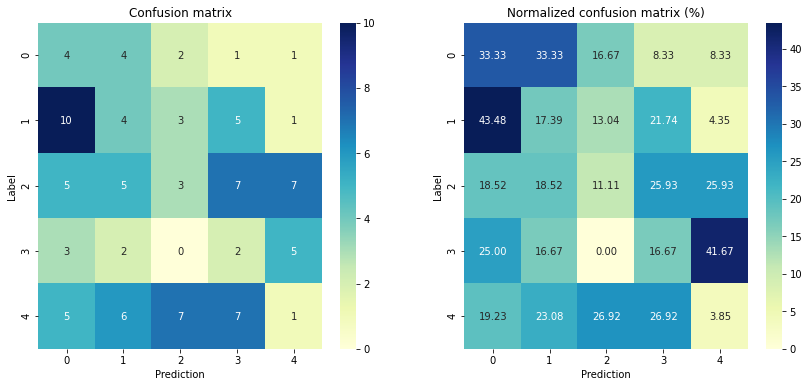

[0.14,
 0.3333333333333333,
 0.17391304347826086,
 0.1111111111111111,
 0.16666666666666666,
 0.038461538461538464,
 0.13279103581481042]

In [ ]:
def get_accs(label,prediction, show=True):
    cm = confusion_matrix(label,prediction)
    length = cm.shape[0]
    num_cases = len(label)
    # global accuracy
    glb_acc = np.trace(cm)/len(label)
    ind_accs = cm/np.sum(cm,axis=1)[:, np.newaxis]
    accs = [ind_accs[i,i] for i in range(length)]
    accs.insert(0,glb_acc)
    # G-mean
    accs.append(geometric_mean_score(label, prediction,correction=0.001))

    if show:
        plt.figure(figsize=(14, 6))
        plt.subplot(1,2,1)
        sns.heatmap(cm, xticklabels=np.arange(length), yticklabels=np.arange(length), 
                    annot=True, fmt='g',cmap="YlGnBu")
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title('Confusion matrix')
        plt.subplot(1,2,2)
        sns.heatmap(ind_accs*100, xticklabels=np.arange(length), yticklabels=np.arange(length), 
                    annot=True, fmt='.2f',cmap="YlGnBu")
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title('Normalized confusion matrix (%)')
        plt.show()
    return accs
get_accs(np.random.randint(5, size=100),np.random.randint(5, size=100))

# Run 4 binary model without any techniques

## Function to train a model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [1]:
def prepare_data(X_dat,label,model):
  # Split data set 
  X_train, X_test, y_train, y_test = train_test_split(X_dat,label,test_size=0.2,stratify=label, random_state=48)
  #print('Training features shape:', X_train.shape)
  #print('Test features shape:', X_test.shape)
  
  # Standardize the data 
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test

In [ ]:
def train_model(X_dat,label,model):

  # and then train it with Logistic Regression
  start = time.time()
  model.fit(X_train, y_train)
  # use the model to make predictions with the test data
  y_pred = model.predict(X_test)
  end= time.time()

  # get the evaluation metrics
  result = get_accs(y_test,y_pred,False)
  result.append(end-start)
  return result

train_model(sets[3][0],sets[3][1],SGDClassifier(loss="hinge", penalty="l2", max_iter=5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[0.7831821929101401,
 0.8588709677419355,
 0.4434389140271493,
 0.6171359730439724,
 0.010880231857299805]

## Train all 4 models with logistic regression

In [ ]:
index = ['Global accuracy', 'Class 1','Class 2','G-mean','Training time']

In [ ]:
rsts = pd.DataFrame()
for i in range(4):
  name = 'Model #{}'.format(i+1)
  #print(name)
  rsts[name] = train_model(sets[i][0],sets[i][1],LogisticRegression(solver = 'lbfgs'))
  
rsts.index = index
rsts

,Model #1,Model #2,Model #3,Model #4
Global accuracy,0.830264,0.677268,0.817138,0.845012
Class 1,0.976630,0.903460,0.969027,0.963710
Class 2,0.159252,0.289295,0.194559,0.312217
G-mean,0.394373,0.511240,0.434204,0.548531
Training time,2.122408,0.280080,0.169982,0.055567


## Train 4 models with 5 different ML algorithms

In [ ]:
def create_ML(cw = None):
  LR = LogisticRegression(solver = 'lbfgs',class_weight=cw)
  DT = DecisionTreeClassifier(random_state=0,class_weight=cw)
  RF = RandomForestClassifier(max_depth=2, random_state=0,class_weight=cw)
  GNB = GaussianNB()
  SGD = SGDClassifier(loss="hinge", penalty="l2", max_iter=5,class_weight=cw)
  clfs = [LR,DT,RF,GNB,SGD]
  names = ['LR','DT','RF','GNB','SGD']
  return dict(zip(names, clfs)) 
create_ML()

{'DT': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'GNB': GaussianNB(priors=None, var_smoothing=1e-09),
 'LR': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'RF': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=2, max_features='auto',
               

In [ ]:
rsts = pd.DataFrame()
for i in range(4):
  MLs = create_ML()
  for clf_name, clf in MLs.items():
    name = '{0} #{1}'.format(clf_name,i+1)
    print(name)
    try:
      rsts[name] = train_model(sets[i][0],sets[i][1],clf)
    except Exception as e: print(e)
    
rsts.index = index
rsts

LR #1
DT #1
RF #1
GNB #1
SGD #1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


LR #2
DT #2
RF #2
GNB #2
SGD #2


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


LR #3
DT #3
RF #3
GNB #3
SGD #3
LR #4


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


DT #4
RF #4
GNB #4
SGD #4


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


,LR #1,DT #1,RF #1,GNB #1,SGD #1,LR #2,DT #2,RF #2,GNB #2,SGD #2,LR #3,DT #3,RF #3,GNB #3,SGD #3,LR #4,DT #4,RF #4,GNB #4,SGD #4
Global accuracy,0.830264,0.744297,0.826457,0.797833,0.825998,0.677268,0.598237,0.654994,0.658150,0.628372,0.817138,0.732902,0.805174,0.793371,0.745675,0.845012,0.763397,0.817807,0.204452,0.790602
Class 1,0.976630,0.833485,0.998597,0.912559,0.993661,0.903460,0.679457,0.984727,0.940228,0.907420,0.969027,0.822204,0.999799,0.909694,0.867458,0.963710,0.840726,1.000000,0.032258,0.886089
Class 2,0.159252,0.335418,0.037282,0.271872,0.057352,0.289295,0.458926,0.089424,0.174321,0.149741,0.194559,0.366859,0.007420,0.316570,0.246496,0.312217,0.416290,0.000000,0.977376,0.361991
G-mean,0.394373,0.528740,0.192950,0.498096,0.238723,0.511240,0.558409,0.296747,0.404847,0.368617,0.434204,0.549211,0.086129,0.536640,0.462412,0.548531,0.591596,0.031623,0.177562,0.566353
Training time,2.154464,12.339162,17.430933,0.325759,0.747814,0.270580,1.567235,2.672159,0.069744,0.155313,0.187151,0.496479,0.957001,0.025012,0.046408,0.055824,0.099946,0.303674,0.004447,0.008009


Print the best performance

In [ ]:
best_rst = []
for i in range(4):
  algo = rsts.loc['G-mean'][i*5:i*5+5].idxmax()
  best_rst.append(algo)
best_rst = rsts[best_rst].copy()
best_rst

,DT #1,DT #2,DT #3,DT #4
Global accuracy,0.744297,0.598237,0.732902,0.763397
Class 1,0.833485,0.679457,0.822204,0.840726
Class 2,0.335418,0.458926,0.366859,0.416290
G-mean,0.528740,0.558409,0.549211,0.591596
Training time,12.339162,1.567235,0.496479,0.099946


# Run 4 binary models with class weights

In [ ]:
rsts = pd.DataFrame()
for i in range(4):
  MLs = create_ML('balanced')
  print(Counter(sets[i][1]))
  for clf_name, clf in MLs.items():
    name = '{0} #{1}'.format(clf_name,i+1)
    print(name)
    try:
      rsts[name] = train_model(sets[i][0],sets[i][1],clf)
    except Exception as e: print(e)
    
rsts.index = index
rsts

Counter({0: 384890, 1: 83954})
LR #1
DT #1
RF #1
GNB #1
SGD #1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Counter({0: 53032, 1: 30922})
LR #2
DT #2
RF #2
GNB #2
SGD #2


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Counter({0: 24859, 1: 6063})
LR #3
DT #3
RF #3
GNB #3
SGD #3
Counter({0: 4959, 1: 1104})
LR #4


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


DT #4
RF #4
GNB #4
SGD #4


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


,LR #1,DT #1,RF #1,GNB #1,SGD #1,LR #2,DT #2,RF #2,GNB #2,SGD #2,LR #3,DT #3,RF #3,GNB #3,SGD #3,LR #4,DT #4,RF #4,GNB #4,SGD #4
Global accuracy,0.716345,0.752935,0.798185,0.797833,0.646973,0.640462,0.599130,0.656006,0.658150,0.597463,0.724656,0.740501,0.776880,0.793371,0.700566,0.767519,0.779885,0.734542,0.204452,0.573784
Class 1,0.751474,0.849671,0.869573,0.912559,0.654265,0.695767,0.687942,0.782596,0.940228,0.637598,0.745575,0.840306,0.848954,0.909694,0.737329,0.798387,0.856855,0.754032,0.032258,0.590726
Class 2,0.555297,0.309451,0.470907,0.271872,0.613543,0.545602,0.446798,0.438875,0.174321,0.528622,0.638912,0.331410,0.481451,0.316570,0.549876,0.628959,0.434389,0.647059,0.977376,0.497738
G-mean,0.645981,0.512769,0.639913,0.498096,0.633577,0.616126,0.554411,0.586056,0.404847,0.580559,0.690186,0.527717,0.639320,0.536640,0.636742,0.708628,0.610089,0.698501,0.177562,0.542242
Training time,2.417888,12.064568,18.013896,0.339224,0.835541,0.290656,1.545057,2.664319,0.069657,0.154221,0.203888,0.470475,0.950562,0.023673,0.046706,0.066664,0.091833,0.311128,0.004409,0.007169


Print the best algorithm for each classfications

In [ ]:
best_rst = []
for i in range(4):
  algo = rsts.loc['G-mean'][i*5:i*5+5].idxmax()
  best_rst.append(algo)
best_rst_cw = rsts[best_rst].copy()
best_rst_cw

,LR #1,LR #2,LR #3,LR #4
Global accuracy,0.716345,0.640462,0.724656,0.767519
Class 1,0.751474,0.695767,0.745575,0.798387
Class 2,0.555297,0.545602,0.638912,0.628959
G-mean,0.645981,0.616126,0.690186,0.708628
Training time,2.417888,0.290656,0.203888,0.066664


# Run 4 binary models with under-sampling


In [ ]:
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour,EditedNearestNeighbours
from imblearn.under_sampling import AllKNN, InstanceHardnessThreshold, NearMiss, NeighbourhoodCleaningRule
from imblearn.under_sampling import     TomekLinks
from imblearn.under_sampling import     OneSidedSelection

In [ ]:
import warnings; warnings.simplefilter('ignore')

In [ ]:
rus = RandomUnderSampler(random_state=42)
#cnn = CondensedNearestNeighbour(random_state=42)
enn = EditedNearestNeighbours(random_state=42)
aknn = AllKNN(random_state=42)
iht = InstanceHardnessThreshold(random_state=42)
nrms =NearMiss(random_state=42)
ncr = NeighbourhoodCleaningRule(random_state=42)
oss = OneSidedSelection(random_state=42)
tml = TomekLinks(random_state=42)

unders = [rus, enn, aknn, iht, nrms, ncr, oss, tml]
under_names = ['RandomUnderSampler',
            'EditedNearestNeighbours', 'AllKNN', 'InstanceHardnessThreshold', 
            'NearMiss', 'NeighbourhoodCleaningRule',
            'OneSidedSelection','TomekLinks']
URs=dict(zip(under_names,unders))
URs

{'AllKNN': AllKNN(allow_minority=False, kind_sel='all', n_jobs=1, n_neighbors=3,
        random_state=42, ratio=None, return_indices=False,
        sampling_strategy='auto'),
 'EditedNearestNeighbours': EditedNearestNeighbours(kind_sel='all', n_jobs=1, n_neighbors=3,
                         random_state=42, ratio=None, return_indices=False,
                         sampling_strategy='auto'),
 'InstanceHardnessThreshold': InstanceHardnessThreshold(cv=5, estimator=None, n_jobs=1, random_state=42,
                           ratio=None, return_indices=False,
                           sampling_strategy='auto'),
 'NearMiss': NearMiss(n_jobs=1, n_neighbors=3, n_neighbors_ver3=3, random_state=42,
          ratio=None, return_indices=False, sampling_strategy='auto', version=1),
 'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule(kind_sel='all', n_jobs=1, n_neighbors=3,
                           random_state=42, ratio=None, return_indices=False,
                           sampling_strateg

In [ ]:
def under_resampling(data,method):
  urs = URs[method]
  X_urs, y_urs = urs.fit_resample(data[0], data[1])
  return X_urs, y_urs
under_resampling(sets[3],under_names[0])

(array([[ 2.,  1.,  1., ..., 19., 31.,  0.],
        [ 1.,  1.,  1., ..., 18., 28.,  1.],
        [ 1.,  1.,  1., ..., 16., 43.,  0.],
        ...,
        [ 1.,  1.,  1., ..., 22., 35.,  0.],
        [ 1.,  1.,  1., ...,  2.,  6.,  1.],
        [ 2.,  1.,  1., ...,  6., 10.,  0.]]), array([0, 0, 0, ..., 1, 1, 1]))

In [ ]:
import warnings; warnings.simplefilter('ignore')

#### Find the fastest under sampling techniques

In [ ]:
print(Counter(sets[2][1]))
perform ={}
for key in ['RandomUnderSampler','NearMiss','EditedNearestNeighbours','TomekLinks','OneSidedSelection']:
  start = time.time()
  under_resampling(sets[1],key)
  end = time.time()
  perform[key]=end-start

sorted(perform.items(), key=lambda x: x[1])

Counter({0: 24859, 1: 6063})


[('RandomUnderSampler', 0.1531369686126709),
 ('NearMiss', 11.372380256652832),
 ('EditedNearestNeighbours', 27.50859570503235),
 ('TomekLinks', 36.5115921497345),
 ('OneSidedSelection', 47.6129515171051)]

Best are ROS, NM, ENN

In [ ]:
def train_model_2(X_dat,label,model,resampler):
  # Split data set 
  X_train, X_test, y_train, y_test = train_test_split(X_dat,label,test_size=0.2,stratify=label, random_state=48)
  #print('Training features shape:', X_train.shape)
  #print('Test features shape:', X_test.shape)

  # Standardize the data 
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  
  # Resampling the training set
  X_train, y_train = resampler.fit_resample(X_train, y_train)

  print(Counter(y_train))
  # and then train it with Logistic Regression
  start = time.time()
  model.fit(X_train, y_train)
  # use the model to make predictions with the test data
  y_pred = model.predict(X_test)
  end= time.time()

  # get the evaluation metrics
  result = get_accs(y_test,y_pred,False)
  result.append(end-start)
  return result

train_model(sets[3][0],sets[3][1],SGDClassifier(loss="hinge", penalty="l2", max_iter=5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[0.7922506183017313,
 0.8568548387096774,
 0.502262443438914,
 0.656022869237635,
 0.008109092712402344]

### Random under resampling


In [ ]:
rsts = pd.DataFrame()
for i in range(4):
  MLs = create_ML('balanced')

  for clf_name, clf in MLs.items():
    name = '{0} #{1}'.format(clf_name,i+1)
    print(name)
    try:
      rus = RandomUnderSampler(random_state=42)
      rsts[name] = train_model_2(sets[i][0],sets[i][1],clf,rus)
    except Exception as e: print(e)
    
rsts.index = index
best_rst = []
for i in range(4):
  algo = rsts.loc['G-mean'][i*5:i*5+5].idxmax()
  best_rst.append(algo)
best_rst_ur = rsts[best_rst].copy()
best_rst_ur

LR #1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 67163, 1: 67163})
DT #1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 67163, 1: 67163})
RF #1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 67163, 1: 67163})
GNB #1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 67163, 1: 67163})
SGD #1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 67163, 1: 67163})


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


LR #2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24738, 1: 24738})
DT #2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24738, 1: 24738})
RF #2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 24738, 1: 24738})
GNB #2
Counter({0: 24738, 1: 24738})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SGD #2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Counter({0: 24738, 1: 24738})
LR #3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 4850, 1: 4850})
DT #3
Counter({0: 4850, 1: 4850})
RF #3
Counter({0: 4850, 1: 4850})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


GNB #3
Counter({0: 4850, 1: 4850})
SGD #3
Counter({0: 4850, 1: 4850})
LR #4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 883, 1: 883})
DT #4
Counter({0: 883, 1: 883})
RF #4
Counter({0: 883, 1: 883})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


GNB #4
Counter({0: 883, 1: 883})
SGD #4
Counter({0: 883, 1: 883})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


,LR #1,LR #2,LR #3,LR #4
Global accuracy,0.717092,0.640522,0.724818,0.751031
Class 1,0.752423,0.696804,0.745173,0.774194
Class 2,0.555119,0.543984,0.641385,0.647059
G-mean,0.646285,0.615671,0.691334,0.707777
Training time,0.848973,0.219364,0.075318,0.035538


## Near Miss

In [ ]:
rsts = pd.DataFrame()
for i in range(4):
  MLs = create_ML('balanced')

  for clf_name, clf in MLs.items():
    name = '{0} #{1}'.format(clf_name,i+1)
    print(name)
    try:
      nrms =NearMiss(random_state=42)
      rsts[name] = train_model_2(sets[i][0],sets[i][1],clf,nrms)
    except Exception as e: print(e)
    
rsts.index = index
best_rst = []
for i in range(4):
  algo = rsts.loc['G-mean'][i*5:i*5+5].idxmax()
  best_rst.append(algo)
best_rst_ur = rsts[best_rst].copy()
best_rst_ur

LR #1
Counter({0: 67163, 1: 67163})
DT #1


## Edited Nearest Neighbours

In [ ]:
rsts = pd.DataFrame()
for i in range(4):
  MLs = create_ML('balanced')
  for clf_name, clf in MLs.items():
    name = '{0} #{1}'.format(clf_name,i+1)
    print(name)
    try:
      enn = EditedNearestNeighbours(random_state=42)
      rsts[name] = train_model_2(sets[i][0],sets[i][1],clf,enn)
    except Exception as e: print(e)
    
rsts.index = index
best_rst = []
for i in range(4):
  algo = rsts.loc['G-mean'][i*5:i*5+5].idxmax()
  best_rst.append(algo)
best_rst_ur = rsts[best_rst].copy()
best_rst_ur

Counter({0: 229742, 1: 83954})
LR #1
DT #1
RF #1
GNB #1
SGD #1
Counter({1: 30922, 0: 16763})
LR #2
DT #2
RF #2
GNB #2
SGD #2
Counter({0: 15087, 1: 6063})
LR #3
DT #3
RF #3
GNB #3
SGD #3
Counter({0: 3307, 1: 1104})
LR #4
DT #4
RF #4
GNB #4
SGD #4


,LR #1,LR #2,LR #3,LR #4
Global accuracy,0.707364,0.627975,0.748227,0.784824
Class 1,0.750223,0.737847,0.780908,0.827795
Class 2,0.590078,0.568402,0.666941,0.656109
G-mean,0.665350,0.647606,0.721679,0.736969
Training time,1.793872,0.538568,0.109077,0.039802


# Run 4 binary models with over-sampling


In [ ]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.over_sampling import ADASYN, BorderlineSMOTE

In [ ]:
ada = ADASYN(random_state=42)
bsm = BorderlineSMOTE(random_state=42)
#ksm = KMeansSMOTE(random_state=42)
ros = RandomOverSampler(random_state=42)
sm = SMOTE(random_state=42)

overs = [ros, sm, bsm, ada]
over_names = ['RandomOverSampler','SMOTE',
            'BorderlineSMOTE', 'ADASYN']
ORs=dict(zip(over_names,overs))
ORs

{'ADASYN': ADASYN(n_jobs=1, n_neighbors=5, random_state=42, ratio=None,
        sampling_strategy='auto'),
 'BorderlineSMOTE': BorderlineSMOTE(k_neighbors=5, kind='borderline-1', m_neighbors=10, n_jobs=1,
                 random_state=42, sampling_strategy='auto'),
 'RandomOverSampler': RandomOverSampler(random_state=42, ratio=None, return_indices=False,
                   sampling_strategy='auto'),
 'SMOTE': SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
       out_step='deprecated', random_state=42, ratio=None,
       sampling_strategy='auto', svm_estimator='deprecated')}

In [ ]:
def over_resampling(data,method):
  urs = ORs[method]
  X_urs, y_urs = urs.fit_resample(data[0], data[1])
  return X_urs, y_urs
_,y_or = over_resampling(sets[3],over_names[0])
Counter(sets[3][1]), Counter(y_or)

(Counter({0: 4959, 1: 1104}), Counter({0: 4959, 1: 4959}))

In [ ]:
i = 2
print(Counter(sets[i][1]))
perform ={}
for key in over_names:
  start = time.time()
  over_resampling(sets[i],key)
  end = time.time()
  perform[key]=end-start

sorted(perform.items(), key=lambda x: x[1])

Counter({0: 24859, 1: 6063})


[('RandomOverSampler', 0.04093647003173828),
 ('SMOTE', 0.36640286445617676),
 ('BorderlineSMOTE', 1.6354360580444336),
 ('ADASYN', 1.8417112827301025)]

### Random over resampling

In [ ]:
rsts = pd.DataFrame()
for i in range(4):
  MLs = create_ML('balanced')
  X_sub, y_sub = over_resampling(sets[i],over_names[0])
  print(Counter(y_sub))
  for clf_name, clf in MLs.items():
    name = '{0} #{1}'.format(clf_name,i+1)
    print(name)
    try:
      rsts[name] = train_model(X_sub,y_sub,clf)
    except Exception as e: print(e)
    
rsts.index = index
best_rst = []
for i in range(4):
  algo = rsts.loc['G-mean'][i*5:i*5+5].idxmax()
  best_rst.append(algo)
best_rst_ur = rsts[best_rst].copy()
best_rst_ur

Counter({0: 384890, 1: 384890})
LR #1
DT #1
RF #1
GNB #1
SGD #1
Counter({1: 53032, 0: 53032})
LR #2
DT #2
RF #2
GNB #2
SGD #2
Counter({0: 24859, 1: 24859})
LR #3
DT #3
RF #3
GNB #3
SGD #3
Counter({0: 4959, 1: 4959})
LR #4
DT #4
RF #4
GNB #4
SGD #4


,DT #1,DT #2,DT #3,DT #4
Global accuracy,0.903745,0.727856,0.889381,0.907258
Class 1,0.822105,0.659376,0.803097,0.831653
Class 2,0.985385,0.796342,0.975664,0.982863
G-mean,0.900050,0.724630,0.885185,0.904102
Training time,24.561789,1.957119,0.676397,0.124658


### SMOTE


In [ ]:
rsts = pd.DataFrame()
for i in range(4):
  MLs = create_ML('balanced')
  X_sub, y_sub = over_resampling(sets[i],over_names[1])
  print(Counter(y_sub))
  for clf_name, clf in MLs.items():
    name = '{0} #{1}'.format(clf_name,i+1)
    print(name)
    try:
      rsts[name] = train_model(X_sub,y_sub,clf)
    except Exception as e: print(e)
    
rsts.index = index
best_rst = []
for i in range(4):
  algo = rsts.loc['G-mean'][i*5:i*5+5].idxmax()
  best_rst.append(algo)
best_rst_ur = rsts[best_rst].copy()
best_rst_ur

Counter({0: 384890, 1: 384890})
LR #1
DT #1
RF #1
GNB #1
SGD #1
Counter({1: 53032, 0: 53032})
LR #2
DT #2
RF #2
GNB #2
SGD #2
Counter({0: 24859, 1: 24859})
LR #3
DT #3
RF #3
GNB #3
SGD #3
Counter({0: 4959, 1: 4959})
LR #4
DT #4
RF #4
GNB #4
SGD #4


,DT #1,RF #2,DT #3,DT #4
Global accuracy,0.840396,0.690331,0.822003,0.850806
Class 1,0.829523,0.713680,0.808528,0.852823
Class 2,0.851269,0.666981,0.835479,0.848790
G-mean,0.840326,0.689935,0.821893,0.850804
Training time,25.816819,4.755466,0.917041,0.207702


### BorderlineSMOTE


In [ ]:
rsts = pd.DataFrame()
j = 2
for i in range(4):
  MLs = create_ML('balanced')
  X_sub, y_sub = over_resampling(sets[i],over_names[j])
  print(Counter(y_sub), over_names[j])
  for clf_name, clf in MLs.items():
    name = '{0} #{1}'.format(clf_name,i+1)
    print(name)
    try:
      rsts[name] = train_model(X_sub,y_sub,clf)
    except Exception as e: print(e)
    
rsts.index = index
best_rst = []
for i in range(4):
  algo = rsts.loc['G-mean'][i*5:i*5+5].idxmax()
  best_rst.append(algo)
best_rst_ur = rsts[best_rst].copy()
best_rst_ur

Counter({0: 384890, 1: 384890}) BorderlineSMOTE
LR #1
DT #1
RF #1
GNB #1
SGD #1
Counter({1: 53032, 0: 53032}) BorderlineSMOTE
LR #2
DT #2
RF #2
GNB #2
SGD #2
Counter({0: 24859, 1: 24859}) BorderlineSMOTE
LR #3
DT #3
RF #3
GNB #3
SGD #3
Counter({0: 4959, 1: 4959}) BorderlineSMOTE
LR #4
DT #4
RF #4
GNB #4
SGD #4


,DT #1,RF #2,DT #3,DT #4
Global accuracy,0.840253,0.684722,0.814662,0.845262
Class 1,0.829796,0.688225,0.804907,0.835685
Class 2,0.850711,0.681218,0.824417,0.854839
G-mean,0.840188,0.684713,0.814604,0.845208
Training time,23.657061,4.647530,0.944167,0.195716


### Adasyn


In [ ]:
rsts = pd.DataFrame()
j = 3
for i in range(4):
  MLs = create_ML('balanced')
  X_sub, y_sub = over_resampling(sets[i],over_names[j])
  print(Counter(y_sub), over_names[j])
  for clf_name, clf in MLs.items():
    name = '{0} #{1}'.format(clf_name,i+1)
    print(name)
    try:
      rsts[name] = train_model(X_sub,y_sub,clf)
    except Exception as e: print(e)
    
rsts.index = index
best_rst = []
for i in range(4):
  algo = rsts.loc['G-mean'][i*5:i*5+5].idxmax()
  best_rst.append(algo)
best_rst_ur = rsts[best_rst].copy()
best_rst_ur

Counter({1: 412121, 0: 384890}) ADASYN
LR #1
DT #1
RF #1
GNB #1
SGD #1
Counter({0: 53032, 1: 52287}) ADASYN
LR #2
DT #2
RF #2
GNB #2
SGD #2
Counter({0: 24859, 1: 24565}) ADASYN
LR #3
DT #3
RF #3
GNB #3
SGD #3
Counter({0: 4959, 1: 4854}) ADASYN
LR #4
DT #4
RF #4
GNB #4
SGD #4


,DT #1,RF #2,DT #3,DT #4
Global accuracy,0.842801,0.683393,0.813556,0.851758
Class 1,0.824807,0.685114,0.805712,0.848790
Class 2,0.859606,0.681649,0.821494,0.854789
G-mean,0.842027,0.683379,0.813565,0.851784
Training time,26.866232,5.106712,0.913328,0.184428


# Variables


In [ ]:
%whos